# Utilizing daal4py in Data Science Workflows

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sys
%matplotlib inline
sys.version

'3.6.5 |Intel Corporation| (default, Aug  3 2018, 14:28:41) \n[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]'

This example will be exploring workout data pulled from Strava, processed into a CSV for Pandas and daal4py usage.

In [55]:
workout_data_dd= pd.read_csv('data/batch/cycling_dataset.csv', index_col=0)

## Explore and visualize some of the data

In general, we are trying to predict on the 'power' in Watts to see if we can generate a model that can predict one's power output without the usage of a cycling power meter.  Below are some basic scatterplots as we explore the data

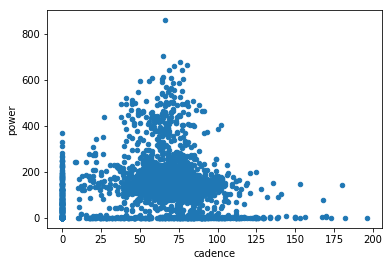

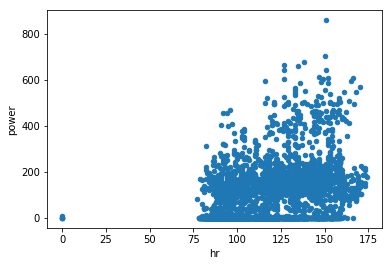

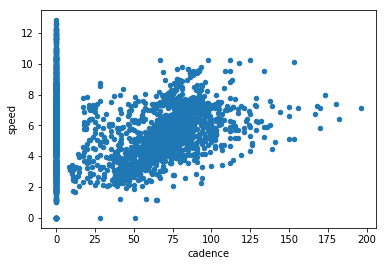

In [56]:
workout_data_dd.plot.scatter('cadence','power')
plt.show()
workout_data_dd.plot.scatter('hr','power')
plt.show()
workout_data_dd.plot.scatter('cadence','speed')
plt.show()

## Using daal4py

In [57]:
import daal4py as d4p

In [58]:
dataset = workout_data_dd
# Reduce the dataset, create X
red_dataset = dataset.drop(['time','power','latitude','longitude'], axis=1)
# Get the target, create Y
target = np.array(dataset.power.values, ndmin=2).T

This is the dataset's columns.  The target is to try to reproduce the Power with other collected data

In [59]:
dataset.columns

Index(['altitude', 'cadence', 'distance', 'hr', 'latitude', 'longitude',
       'power', 'speed', 'time'],
      dtype='object')

X is 5 features by 3k rows

In [60]:
red_dataset.values.shape

(3902, 5)

Y is 3k rows by 1 column

In [61]:
target.shape

(3902, 1)

## Training the model

Create the Linear Regression Model, and train the model with the data

In [62]:
d4p_lm = d4p.linear_regression_training(interceptFlag=True)
lm_trained = d4p_lm.compute(red_dataset.values, target)

In [63]:
print("Model has this number of features: ", lm_trained.model.NumberOfFeatures)

Model has this number of features:  5


## Prediction (inference) with the trained model

A small test to make the trained model works

In [64]:
subset = red_dataset.values[0:300]

Create the Prediction object and use the reduced dataset for prediction

In [65]:
lm_predictor_component = d4p.linear_regression_prediction()
result = lm_predictor_component.compute(subset, lm_trained.model)

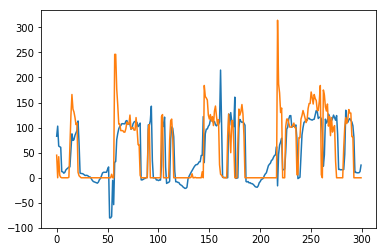

In [66]:
plt.plot(result.prediction)
plt.plot(dataset.power.values[0:300])
plt.show()

The graph above shows the Orange (predicted) result over the Blue (original data).  This data is notoriously sparse in features leading to a difficult to predict target!

## Model properties
Another aspect of the model is the trained model's properties, which are explored below

In [67]:
print("Betas:",lm_trained.model.Beta) 
print("Number of betas:", lm_trained.model.NumberOfBetas)
print("Number of Features:", lm_trained.model.NumberOfFeatures)

Betas: [[ 2.15694521e+01 -4.07018021e-01  1.25842017e+00 -1.08321625e-03
   1.32804376e+00 -1.00941542e+01]]
Number of betas: 6
Number of Features: 5


In [68]:
red_dataset.head()

,altitude,cadence,distance,hr,speed
0,185.800003,51,3.46,81,3.459
1,185.800003,68,7.17,82,3.710
2,186.399994,38,11.04,82,3.874
3,186.800003,38,15.18,83,4.135
4,186.600006,38,19.43,83,4.250


## Additional metrics
We can generate metrics on the independent data with daal4py's low_order_moments() class.

In [69]:
metrics_processor = d4p.low_order_moments()
data = metrics_processor.compute(red_dataset.values)
data.standardDeviation

array([[2.50671012e+01, 3.78765011e+01, 6.38596014e+03, 2.27698869e+01,
        1.89024994e+00]])

## Migrating the trained model for inference on external systems

In [70]:
import pickle

In [71]:
with open('trained_model2.pickle', 'wb') as model_pi:
    pickle.dump(lm_trained.model, model_pi)
    model_pi.close

The trained model file above can be moved to an inference-only or embedded system.  This is useful if the training is extreamly heavy or computed-limited.  

In [72]:
with open('trained_model2.pickle', 'rb') as model_import:
    lm_import = pickle.load(model_import)

The imported model from file is now usable again:

In [73]:
lm_import.Beta

array([[ 2.15694521e+01, -4.07018021e-01,  1.25842017e+00,
        -1.08321625e-03,  1.32804376e+00, -1.00941542e+01]])